In [1]:
#import os
#import sys
#import time

import pandas as pd
import numpy as np
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from astropy.convolution import convolve, Box1DKernel

import scipy
from scipy import signal
from scipy import optimize
from scipy import stats
import scipy.fftpack
from scipy.optimize import minimize

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Defining some used mathematical functions

In [2]:
exptime = 1765.3248
'''
Np = 204
N = len(data) // Np
N_mod = len(data) % Np
'''

def fft(flux, exptime=exptime):
    N1 = np.size(flux)
    w = scipy.fftpack.rfft(flux)
    freq_f = scipy.fftpack.rfftfreq(N1,exptime)
    spectrum = w**2
    return freq_f, spectrum


def ls(time, flux, P_min=0.1, P_max=1, space=10000):
    freq_ls = np.linspace(P_min, P_max, space)
    pgram = signal.lombscargle(time, flux, freq_ls, normalize=False)
    return freq_ls, pgram


def acf_value(flux, nlags):
    ts_acf = sm.tsa.stattools.acf(flux, nlags)
    return ts_acf


def phase_cut(df0, time, N, Np):
    dic = {}
    for i in range(N+1):
        if (Np*(i+1)+i < len(df0)):
            dic[i] = pd.DataFrame(df0[Np*i+i:Np*(i+1)+i+1])
        else:
            dic[i] = pd.DataFrame(df0[Np*i+i:len(data)])
        df = dic[i]
        df['PHASE']=(df['TIME']-df['TIME'][Np*i+i])/(time[Np]-time[0])
        #phase = df['PHASE']
        #flux = df['flux_n-slope']
    fname = []
    for i in range(N+1):
        fname.append(dic[i])
    comb_data = pd.concat(fname)
    #Sort the data with phase
    comb_data_s = comb_data.sort_values('PHASE')
    return comb_data_s


def rms(flux):
    return np.sqrt((flux**2).sum()/flux.size)


def rms_mag_model(flux, flux_model):
    residuals = -2.5 * np.log10(flux/flux_model)
    return np.sqrt(np.mean((residuals)**2)) 


def boxcar(phase, flux, comb_data_s, width=25):
    box = Box1DKernel(width)
    sm_signal = convolve(flux, box, boundary='extend')
    comb_data_s['boxcar'] = sm_signal
    return sm_signal


def binning(df0, phase, bc_model, N, N_mod, bins):
    #flux model bin
    bin_means, bin_edges, binnumber = stats.binned_statistic(phase, bc_model,
                                                             statistic='median', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return bin_means
'''
#add binning data to dataframe
bc_model = pd.Series(bin_means,'model')
bc_model_rest = pd.Series(bin_means[:N_mod],'model')
sm = {}
for i in range(N):
    sm[i] = bc_model
bc_model_comb = pd.concat(sm,ignore_index=True)
bc_model_comb1 = pd.concat([bc_model_comb,bc_model_rest],ignore_index=True)
df_after = pd.concat([df0,bc_model_comb1],axis=1)
'''


"\n#add binning data to dataframe\nbc_model = pd.Series(bin_means,'model')\nbc_model_rest = pd.Series(bin_means[:N_mod],'model')\nsm = {}\nfor i in range(N):\n    sm[i] = bc_model\nbc_model_comb = pd.concat(sm,ignore_index=True)\nbc_model_comb1 = pd.concat([bc_model_comb,bc_model_rest],ignore_index=True)\ndf_after = pd.concat([df0,bc_model_comb1],axis=1)\n"

### Import data

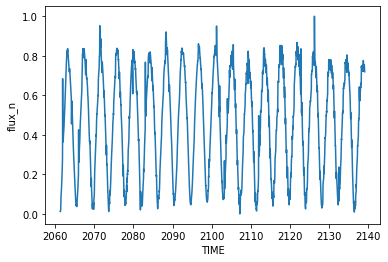

In [3]:
data = pd.read_csv('EPIC203318214_1.csv')

time = data['TIME']
f_n = data['flux_n']
f_n_m = data['flux_n-median']

fig=plt.figure()
plt.plot(time, f_n,  markersize=4)
plt.tick_params(labelsize=10)
#plt.ylim(0.9,1.1)
              
plt.xlabel(time.name)
plt.ylabel(f_n.name)
              
plt.show()

### FFT

(0, 250000.0)

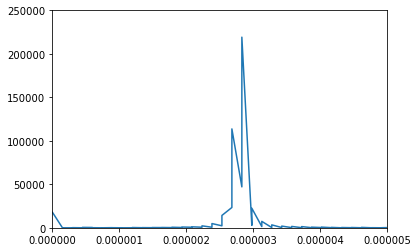

In [4]:
freq_fft, power_fft = fft(f_n_m)
plt.plot(freq_fft, power_fft)
plt.xlim(0,5e-6)
plt.ylim(0,2.5e5)

In [5]:
p_fft = freq_fft[power_fft>1.5e5]
print(1/p_fft/60**2/24)

[4.09177684]


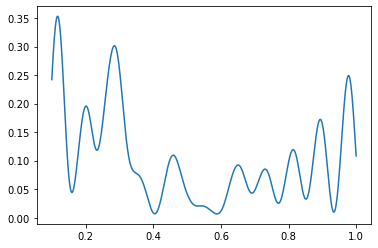

In [6]:
#lomb scargle
freq_ls, power_ls = ls(time, f_n_m)
plt.plot(freq_ls, power_ls)

### ACF

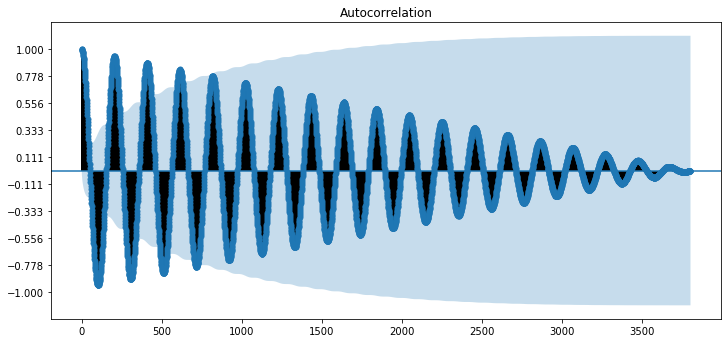

In [7]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax1.set_yticks(np.linspace(-1,1,10))
fig = sm.graphics.tsa.plot_acf(f_n, lags=3804, ax=ax1)
#ax2 = fig.add_subplot(212)
#fig = sm.graphics.tsa.plot_pacf(flux, lags=1500, ax=ax2)

In [8]:
acf_values = sm.tsa.stattools.acf(f_n,nlags=3804)
acf_values[200:210]
#204 has largest value

/Users/yuka/miniconda3/envs/afapphot/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([0.92729981, 0.93092448, 0.93394613, 0.93629507, 0.93736191,
       0.93662426, 0.93462079, 0.93190922, 0.9284531 , 0.92428108])

In [10]:
print(204*exptime/60/60/24,time[204]-time[0])

4.168128 4.1599999999998545


### Folding data

In [10]:
# Define the values to fold the data
Np = 204
N = len(data) // Np
N_mod = len(data) % Np

In [11]:
split_data = phase_cut(data, time, N, Np)
phase = split_data['PHASE']
f_n_sp = split_data['flux_n']
f_n_m_sp = split_data['flux_n-median']
#split_data

(-1.3, 0.6)

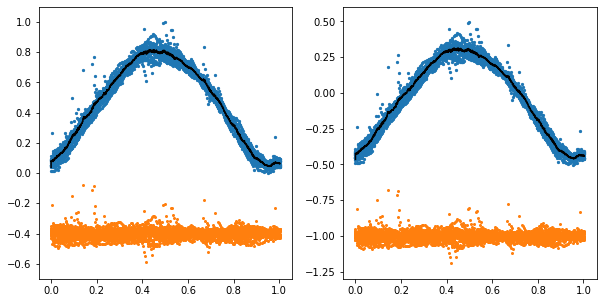

In [17]:
#boxcar-smoothing (folding data)
#normarize flux version
bc_lc = boxcar(phase, f_n_sp, split_data)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(phase, f_n_sp, s=5)
plt.plot(phase, bc_lc, c='black')
plt.scatter(phase, f_n_sp - bc_lc - 0.4, s=4)
plt.ylim(-0.7,1.1)

#normarize flux - median version
bc_lc_m = boxcar(phase, f_n_m_sp, split_data)
plt.subplot(122)
plt.scatter(phase, f_n_m_sp, s=5)
plt.plot(phase, bc_lc_m, c='black')
plt.scatter(phase, f_n_m_sp - bc_lc_m - 1, s=4)
plt.ylim(-1.3,0.6)

(-1.3, 0.6)

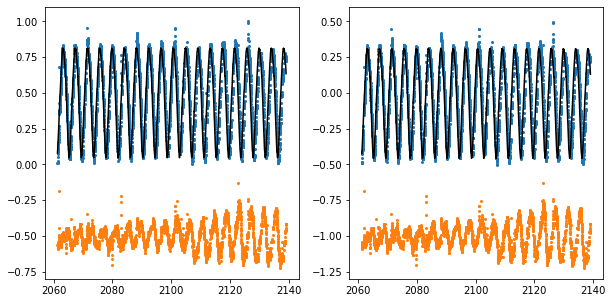

In [18]:
#binning the boxcar-smoothing LC
bins = np.linspace(0, 1, Np+1)
#normarize flux version
 #binning
bin_mean = binning(data, phase, bc_lc , N, N_mod, bins)
 #combine data
bc_model = pd.Series(bin_mean,name='model')
bc_model_rest = pd.Series(bin_mean[:N_mod],name='model')
sm = {}
for i in range(N):
    sm[i] = bc_model
    bc_model_comb = pd.concat(sm,ignore_index=True)
    bc_model_comb1 = pd.concat([bc_model_comb,bc_model_rest],ignore_index=True)
    data_after0 = pd.concat([data,bc_model_comb1],axis=1)


#normarize flux - median version
 #binning
bin_mean_m = binning(data, phase, bc_lc_m , N, N_mod, bins)
 #combine data
bc_model_m = pd.Series(bin_mean_m, name='model_m')
bc_model_rest_m = pd.Series(bin_mean_m[:N_mod],name='model_m')
sm_m = {}
for i in range(N):
    sm_m[i] = bc_model_m
    bc_model_comb_m = pd.concat(sm_m,ignore_index=True)
    bc_model_comb1_m = pd.concat([bc_model_comb_m,bc_model_rest_m],ignore_index=True)
    data_after = pd.concat([data_after0,bc_model_comb1_m],axis=1)



time = data_after['TIME']
f_n = data_after['flux_n']
f_n_m = data_after['flux_n-median']
bc_model = data_after['model']
bc_model_m = data_after['model_m']
resid = f_n - bc_model
resid_m = f_n_m - bc_model_m

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(time, f_n, s=4)
plt.plot(time, bc_model, c='black')
plt.scatter(time, resid - 0.5, s=4)
plt.ylim(-0.8, 1.1)

plt.subplot(122)
plt.scatter(time, f_n_m, s=4)
plt.plot(time, bc_model_m, c='black')
plt.scatter(time, resid_m - 1, s=4)
plt.ylim(-1.3, 0.6)

### Calculate the Q value
$$Q = \frac{(rms_{resid}^2 - \sigma^2)}{(rms_{raw}^2 - \sigma^2)}$$

$rms_{resid}$ : the rms values of the phase-subtracted light curve   
$rms_{raw}$ : the rms values of the raw light curve   
$\sigma$ : the estimated uncertainty including the systematics

this target (Cody2018) : Q = 0.03

In [19]:
rms_raw = rms(f_n)
rms_resid = rms(resid)

rms_raw_m = rms(f_n_m)
rms_resid_m =rms(resid_m)

Q_value = rms_resid**2/rms_raw**2
Q_value_m = rms_resid_m**2/rms_raw_m**2
print(rms_raw, rms_resid,Q_value)
print(rms_raw_m, rms_resid_m, Q_value_m)

0.5376242496121554 0.08614482775882258 0.025674424361438714
0.26497602565987355 0.0861448277588226 0.10569276273972215


### comment : rms(normarized flux - median) is incorrect because the flux have minus values

## M value

$$
    M = \frac{(<d_{10\%}>-d_{med})}{\sigma_d}
$$
 
$d_{10\%}$ : the mean of all data at the top and bottom decile of light curve    
$d_{med}$ : the median of the entire light curve   
$\sigma_d$ : its overall rms  

this target (Cody2018) : M = 0.19

<function matplotlib.pyplot.ylim>

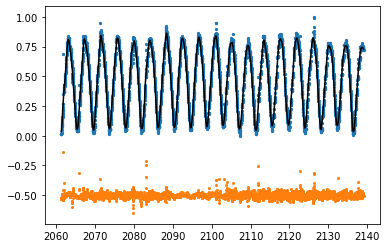

In [20]:
#boxcar smoothing (time-series data)
bc_flux = boxcar(time, f_n, data_after)
data_after['resid'] = f_n - bc_flux
resid_all = data_after['resid']

plt.scatter(time, f_n, s=5)
plt.plot(time, bc_flux, c='black')
plt.scatter(time, f_n - bc_flux - 0.5 , s=4)
plt.ylim

In [21]:
data_no_outlier = pd.DataFrame()
clip = sigma_clip(resid_all,sigma=5)
 
try:
    #just in case there is any outlier try the following:
        
    #identify the index of that outlier
    idx = resid_all[clip.mask].index.values
        
    #using idx, drop/remove the entire row where the outlier is found
    data_no_outlier = data_after.drop(data_after.index[idx], axis=0)
    
except:
    #if there is no outlier, just pass or do nothing 
    pass

In [22]:
df_sort = data_no_outlier.sort_values('flux_n')
df_sort1 = df_sort.reset_index()
flux_raw_split = df_sort1['flux_n']

#the mean of all data at the top and bottom decile of light curve
flux_devide = len(df_sort1)//10
flux_min = flux_raw_split[:379]
flux_max = flux_raw_split[-379:]
d_10 = (sum(flux_min) + sum(flux_max))/(len(flux_min) + len(flux_max))

#the median of the entire light curve
d_med = np.median(flux_raw_split)

sigma_d = rms(flux_raw_split)
M_value = (d_10-d_med)/sigma_d
print(d_10, d_med, M_value)

0.4387222722998649 0.5031641767353374 -0.12014104424949804
